## General Imports

In [139]:
# numpy and pandas for data manipulation

from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
from imblearn.over_sampling import SMOTE
import numpy as np
from collections import Counter
from sklearn.metrics import mean_squared_error
import pandas as pd 
import xgboost as xgb
from sklearn.metrics import accuracy_score
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
import statsmodels.api as sm 
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Function Decleration


In [45]:
def zscore_outliers(x, cutoff=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    dmean = x.mean()
    dsd = x.std()
    rng = dsd * cutoff
    lower = dmean - rng
    upper = dmean + rng
    if return_thresholds:
        return lower, upper
    else:
        return [True if z < lower or z > upper else False for z in x]


def iqr_outliers(x, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25 = np.percentile(x, 25)
    q75 = np.percentile(x, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if z < lower or z > upper else False for z in x]
    
    
def generate_pie_from_df(df, key, title=None, radius=1):
    if title is None:
        title = key
    
    lable_list = []
    data = df.groupby(key).size()
    for label in data.keys().tolist():
        list_percent = round(len(df.loc[df[key] == label]) / len(df) * 100)
        list_item = str(list_percent) + '%' + ' ' + str(label)
        lable_list.append(list_item)  

    plt.title(title)
    
    a = plt.pie(data.tolist(),labels=lable_list, shadow=True, radius=radius)
    
def generate_ols(y, x):
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns
    
def validate_missing_value(df_full, df, col_name):
    col_name_fixed = col_name + "_NA"
    #generate 0 and 1 column
    df[col_name_fixed] = 0
    df.loc[(df[col_name].isnull()), [col_name_fixed]] = 1
    #generate the ols
    X2 = sm.add_constant(df_full)
    model = sm.OLS(df[col_name_fixed], X2.astype(float))
    results  = model.fit()
    df.drop(columns=[col_name_fixed], inplace=True)
    return ((results.pvalues < 0.05).value_counts()[1] / len(results.pvalues)) *100
    
def is_normal_distribution(df):
    np.random.seed(28041990)
    k2, p = stats.normaltest(df)
    print("p = {:g}".format(p))
    return p > 1e-3

def create_missing_column(df, col):
    col_name_miss = col + '_MISSING'
    df[col_name_miss] = 0
    df.loc[(df[col].isnull()), [col_name_miss]] = 1
    df.drop(columns=[col], inplace=True)
    
def encode_quartile(df, col):
    temp_col_name = col + '_tmp'
    df[temp_col_name] = "NA"
    desc = df[col].describe()
    int_25 = desc['25%'].astype(int)
    int_50 = desc['50%'].astype(int)
    int_75 = desc['75%'].astype(int)
    
    df.loc[(df[col] <= int_25), [temp_col_name]] = 'Q1'
    df.loc[(df[col] > int_25) & (df[col] <= int_50), [temp_col_name]] = 'Q2'
    df.loc[(df[col] > int_50) & (df[col] <= int_75), [temp_col_name]] = 'Q3'
    df.loc[(df[col] > int_75) , [temp_col_name]] = 'Q4'
    
    #drop original col
    df.drop(columns=[col], inplace=True)
    #rename the cole to original
    df.rename(index=str, columns={temp_col_name: col}, inplace=True)

    
    
    
# def show_distribution_for_df(df, x, y):
    
#     plt.figure(figsize = (10, 8))

#     # KDE plot of loans that were repaid on time
#     sns.kdeplot(master_df.loc[master_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

#     # KDE plot of loans which were not repaid on time
#     sns.kdeplot(master_df.loc[master_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

#     # Labeling of plot
#     plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

## Data Import

In [46]:
# Training data
master_df = pd.read_csv('./application_train.csv')
print('Size of master_df data', master_df.shape)

Size of master_df data (307511, 122)


## Data exploration


Here we will see the relationships between the various datasets:
![alt text](home_credit.png "Home Credit")

In [47]:
master_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
master_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [205]:
master_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

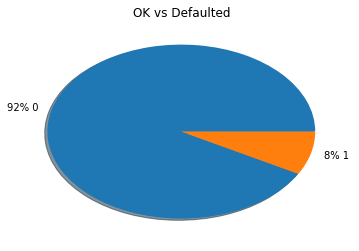

In [6]:
generate_pie_from_df(master_df, 'TARGET', 'OK vs Defaulted')

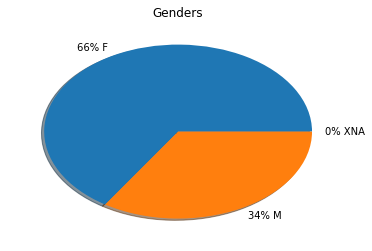

In [7]:
generate_pie_from_df(master_df, 'CODE_GENDER', 'Genders')

In [49]:
#change DAYS_BIRTH to positive
master_df['DAYS_BIRTH'] = abs(master_df['DAYS_BIRTH'])

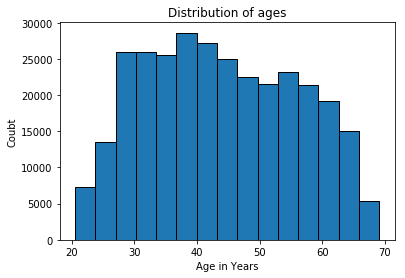

In [50]:
#show distribution by age
plt.hist(master_df['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 15)
plt.title('Distribution of ages'); 
plt.xlabel('Age in Years'); 
plt.ylabel('Coubt');

Text(0.5,1,'Distributuion by age')

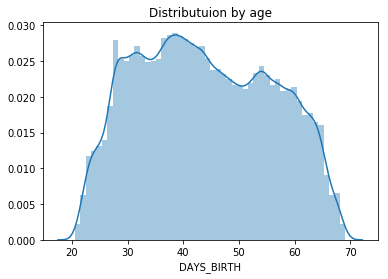

In [27]:
sns.distplot(master_df['DAYS_BIRTH'] / 365).set_title("Distributuion by age")

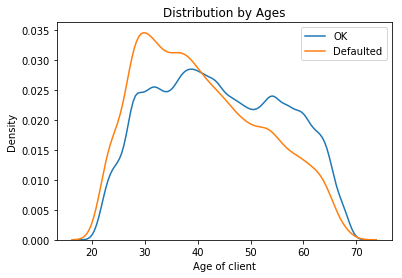

In [51]:
sns.kdeplot(master_df.loc[master_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'OK')
sns.kdeplot(master_df.loc[master_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Defaulted')
plt.xlabel('Age of client'); plt.ylabel('Density'); plt.title('Distribution by Ages');

Text(0.5,1,'Boxplot by AGE')

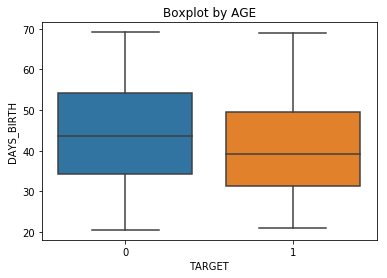

In [29]:
#here we can see that the median age for people that defaulted is lower than those who are not.
sns.boxplot(y=master_df['DAYS_BIRTH']/365,x=master_df['TARGET']).set_title("Boxplot by AGE" )

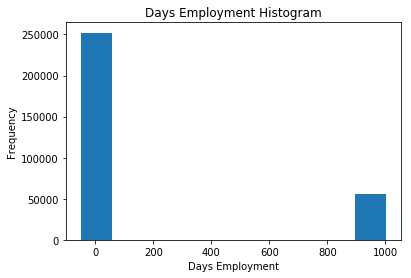

In [52]:
#lets see the distribution of employment in years
(master_df['DAYS_EMPLOYED'] /365 ).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

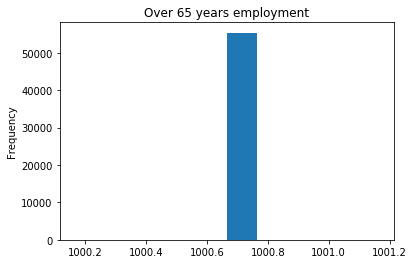

In [53]:
#clearly there is an outlier because no one works for 1000 years.
# lets see who works over 65 yers
(master_df['DAYS_EMPLOYED'] /365).where(master_df['DAYS_EMPLOYED'] > 65).plot.hist(title = 'Over 65 years employment');

In [54]:
#lets describe
(master_df['DAYS_EMPLOYED'] /365).where(master_df['DAYS_EMPLOYED'] > 65).describe()
#since max an min are the same number. without calculating the years abnd running a describe() function 
#we undestand that there is only one outlier which is 365243
#lets create an outlier field and set the DAYS_EMPLOYED to null for the ouylier values
master_df['DAYS_EMPLOYED_OUTLIER'] = master_df["DAYS_EMPLOYED"] == 365243
master_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


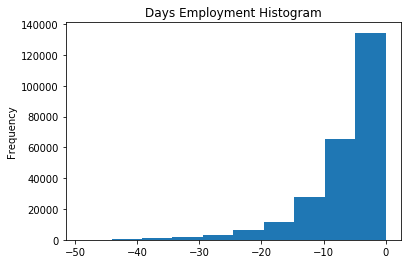

In [55]:
#lets check now
(master_df['DAYS_EMPLOYED'] /365 ).plot.hist(title = 'Days Employment Histogram');

In [217]:
#looks good

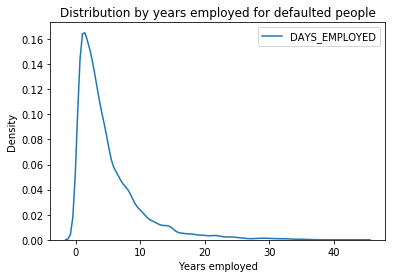

In [34]:
#lets look at the distribution of years employed and defalted people

sns.kdeplot(master_df.loc[master_df['TARGET'] == 1, 'DAYS_EMPLOYED'] / -365)
plt.xlabel('Years employed'); 
plt.ylabel('Density'); 
plt.title('Distribution by years employed for defaulted people');

In [186]:
# as we suspected - people that defaulted tend to work less

## encoding data


In [187]:
#There are 16 clumns that are string based and therefore they must be categorical data
#for columns that have only two otions we will use label incoding , if the columns have mor then two optnse we will use one hot encoding

In [56]:
# configure one hot and label encoding using LabelEncoder nad get_dummies
le = LabelEncoder()

for column in master_df.select_dtypes('object'):
    if len(list(master_df[column].unique())) == 2:
        le.fit(master_df[column])
        master_df[column] = le.transform(master_df[column])

#set the rest with one hot
master_df = pd.get_dummies(master_df)


In [57]:
#we can see that we dont have categorical data anymore
master_df.dtypes.value_counts()


uint8      134
float64     66
int64       40
int32        3
bool         1
dtype: int64

In [16]:
#early on we saw that mant columns has negative values, lets get a list of all columns


In [58]:
for col in master_df.columns:
    values = (master_df[col].dropna() <= 0).value_counts()
    if (len(values) == 1 and values.index[0]):
        print(col)
    

DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
DAYS_LAST_PHONE_CHANGE


In [59]:
#lets change the the negative values 
master_df['DAYS_EMPLOYED'] = abs(master_df['DAYS_EMPLOYED'])
master_df['DAYS_REGISTRATION'] = abs(master_df['DAYS_REGISTRATION'])
master_df['DAYS_ID_PUBLISH'] = abs(master_df['DAYS_ID_PUBLISH'])
master_df['DAYS_LAST_PHONE_CHANGE'] = abs(master_df['DAYS_LAST_PHONE_CHANGE'])



## missing values


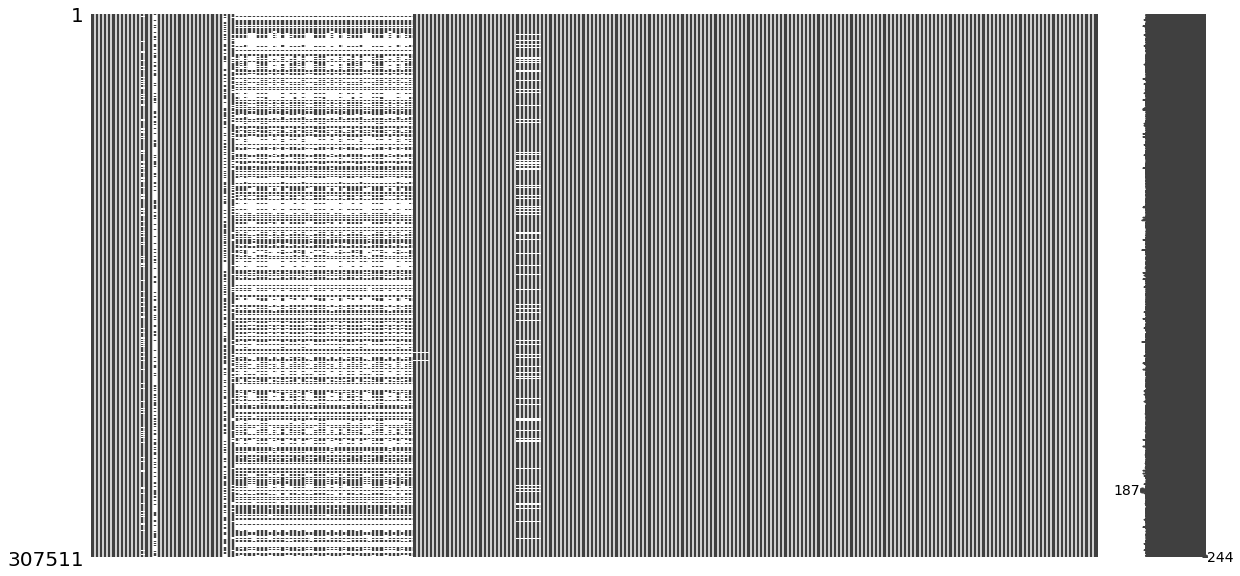

In [414]:
msno.matrix(master_df, inline=True, sparkline=True, figsize=(20,10), sort=None)

In [65]:
missing_columns = missing_values_table(master_df)

Your selected dataframe has 354 columns.
There are 9 columns that have missing values.


In [61]:
missing_columns

,Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_MODE,208642,67.8


In [62]:
full_df = master_df[master_df.columns.difference(missing_columns.index.tolist())]

In [438]:
for col in missing_columns.index.tolist(): 
    missing_values = validate_missing_value(full_df, master_df, col)
    missing_rows = (master_df[master_df[col].isna()])['TARGET']
    if len(missing_rows.value_counts()) == 1:
        if missing_rows.values[0] == 0:
            default_row_count = 0
        else:
            default_row_count = missing_rows.value_counts()[0]
    else:
        default_row_count = missing_rows.value_counts()[1]
    default_percent = (default_row_count / len(missing_rows)) *100
    print('{} pvalues: {} missing rows {} missing rows defaulted {} default percent {}'.format(col, round(missing_values), len(missing_rows), default_row_count, round(default_percent)))
    

COMMONAREA_MODE pvalues: 42.0 missing rows 214865 missing rows defaulted 18423 default percent 9.0
COMMONAREA_AVG pvalues: 42.0 missing rows 214865 missing rows defaulted 18423 default percent 9.0
COMMONAREA_MEDI pvalues: 42.0 missing rows 214865 missing rows defaulted 18423 default percent 9.0
NONLIVINGAPARTMENTS_MEDI pvalues: 44.0 missing rows 213514 missing rows defaulted 18327 default percent 9.0
NONLIVINGAPARTMENTS_AVG pvalues: 44.0 missing rows 213514 missing rows defaulted 18327 default percent 9.0
NONLIVINGAPARTMENTS_MODE pvalues: 44.0 missing rows 213514 missing rows defaulted 18327 default percent 9.0
LIVINGAPARTMENTS_MODE pvalues: 44.0 missing rows 210199 missing rows defaulted 18122 default percent 9.0
LIVINGAPARTMENTS_MEDI pvalues: 44.0 missing rows 210199 missing rows defaulted 18122 default percent 9.0
LIVINGAPARTMENTS_AVG pvalues: 44.0 missing rows 210199 missing rows defaulted 18122 default percent 9.0
FLOORSMIN_MODE pvalues: 44.0 missing rows 208642 missing rows defau

In [155]:
#all of the columns above show strong realtion to the data. after debating about we decided to cutoff all the rows below 1021
#and do a quartile encoding on the rest

In [63]:
#quartile encoding to columns that have above 1021 rows
for col in missing_columns.index:
    if col in missing_columns[(missing_columns['Missing Values'] > 1021)].index.tolist():
        encode_quartile(master_df, col)


In [66]:
# delete all the rows that below 1021 of data
print(str(len(master_df)))
master_df.dropna(subset=
                 (missing_columns['Missing Values'] <= 1021).keys().tolist()
                 , inplace=True)
print(str(len(master_df)))

307511
305545


In [ ]:
master_df = pd.get_dummies(master_df)

In [67]:
#do we have missing values?
missing_values_table(master_df)

Your selected dataframe has 354 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## outlier handling


In [68]:
master_df.shape

(305545, 354)

In [ ]:
# lest see who is a candidate for outlie
for col in master_df.columns:
    if ((master_df[col] > 1).value_counts().index[0] == True):
        print(col)

In [ ]:
#after visializtion we decided to continue to feature impotrance 

## feature importance

In [70]:
master_df.to_csv('./application_train_after_missing.csv')

In [71]:
prog_df = pd.read_csv('./application_train_after_missing.csv')

In [72]:
y = prog_df['TARGET']

In [73]:
X = prog_df.drop(columns=['TARGET'])

In [140]:
data_dmatrix = xgb.DMatrix(data=X)

In [141]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.1, max_depth = 3, alpha = 10, n_estimators = 100, scale_pos_weight=9)

In [142]:
xg_reg.fit(X,y)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=1)

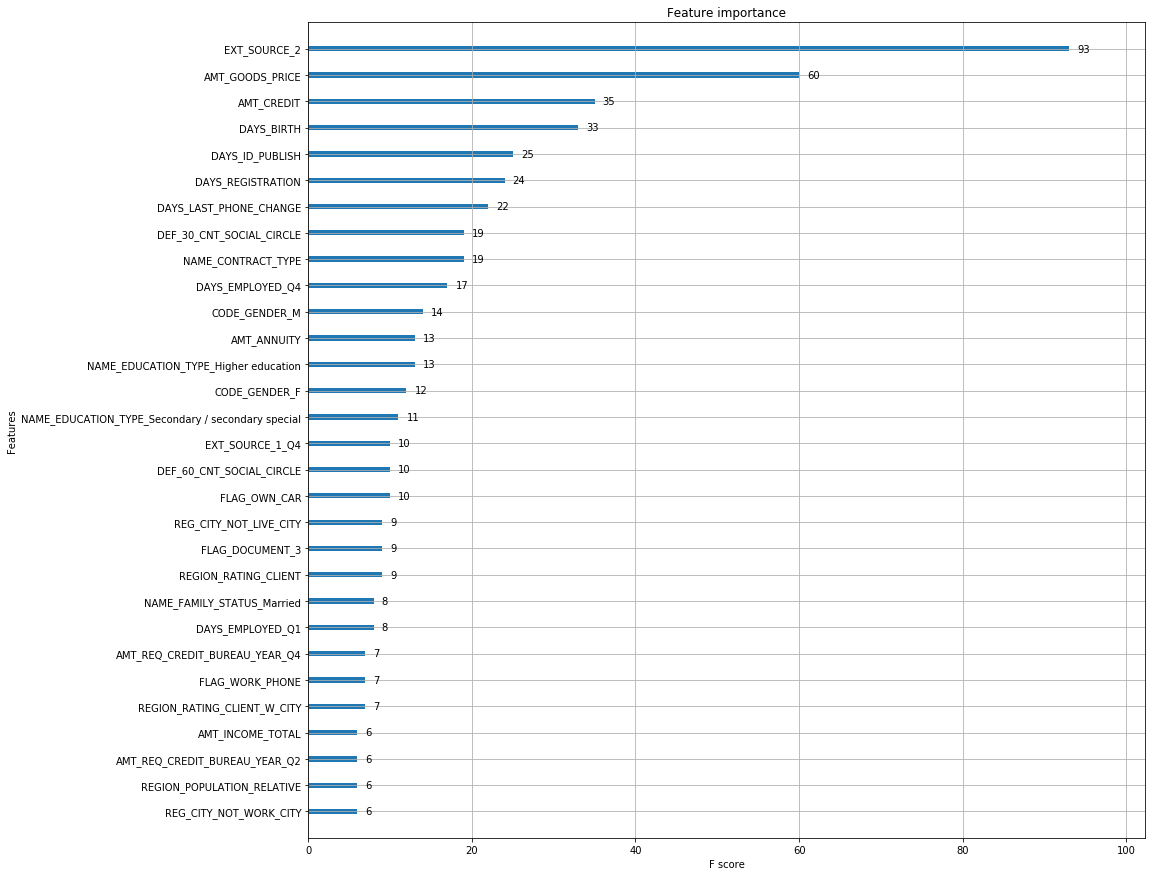

In [143]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(xg_reg,max_num_features=30, ax=ax)

In [ ]:
lasso, random forest, svm

In [162]:
from sklearn import linear_model

In [163]:
clf = linear_model.Lasso(alpha=0.1,)
clf.fit(X,y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [169]:
print(clf.coef_)
print(clf.intercept_)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

'cyclic'

In [167]:
len(clf.coef_)

354